In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import textwrap
import json
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
import functions
import math
from typing import List, Optional, Tuple
from tabulate import tabulate
from collections import defaultdict

random.seed(1213870)

/home/ucloud/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Meta Analysis Plot
meta analysis performance interval = 0.63 - 0.97

In [2]:
# preparing the data for the meta plot
# Define folder path
folder_path = "./results/test"

# Collect files
files = [
os.path.join(root, file)
for root, _, files in os.walk(folder_path)
for file in files
if '_classification_report' in file
]

# Initialize lists to store results
f1_scores_td = []
f1_scores_asd = []
f1_averages = []
test_names = []
test_types = []

# looping through all models
for file_path in files:

    filename = os.path.basename(file_path)
    name_suffix = filename.find('_participant_classification_report')
    test_name = filename[:name_suffix - 2]
    test_names.append(test_name)
    if "MG" in test_name and "Qfam" in test_name:
        test_type = 'Different Task'
    elif "Qfam" in test_name and "Qunfam" in test_name:
        test_type = 'Different Familiarity'  
    else:
        test_type = 'Within'

    test_types.append(test_type)

    # Load classification report
    classification_report = pd.read_csv(file_path)

    # Extract F1 scores
    f1_td = classification_report.iloc[2, 0]
    f1_asd = classification_report.iloc[2, 1]
    f1_average = classification_report.iloc[2, 4] # changed to weighted average
    f1_scores_td.append(f1_td)
    f1_scores_asd.append(f1_asd)
    f1_averages.append(f1_average)

# Combine results into a DataFrame
results = pd.DataFrame({
    'test_type': test_types,
    'test_name': test_names,
    'F1_score_td': f1_scores_td,
    'F1_score_asd': f1_scores_asd,
    'F1_average': f1_averages
})

# taking the mean across runs:
results_grouped = results.groupby(['test_name', 'test_type'], as_index=False).mean()
# Sort the DataFrame by test_type
results = results_grouped.sort_values('test_type')

# diving results into within, task, familiarity and meta:
within = results[results['test_type'] == 'Within']
within = within[['F1_average', 'test_type']]
task = results[results['test_type'] == 'Different Task']
task = task[['F1_average', 'test_type']]
familiarity = results[results['test_type'] == 'Different Familiarity']
familiarity = familiarity[['F1_average', 'test_type']]
meta = [0.63, 0.97]
metas = pd.DataFrame({'F1_average': meta, 'test_type': 'Meta Analysis'})

# Concatenate into one DataFrame
data = pd.concat([metas, within, task, familiarity,])

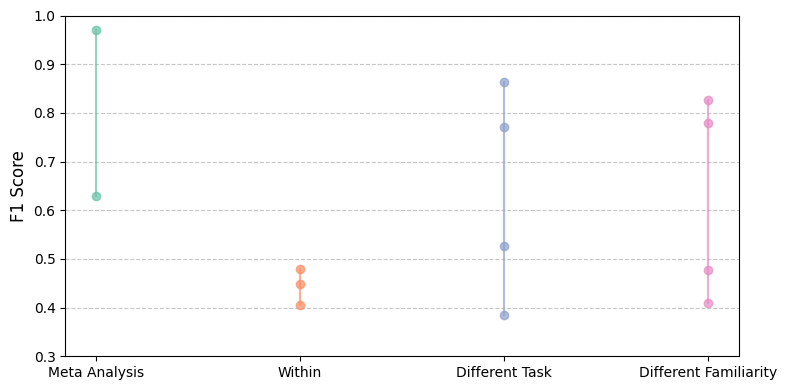

In [3]:
# creating the plot
plt.figure(figsize=(8, 4))

# Define a color palette for the categories
palette = sns.color_palette("Set2", n_colors=len(data['test_type'].unique()))

# Plot lines connecting points within each category
for i, category in enumerate(data['test_type'].unique()):
    subset = data[data['test_type'] == category]
    # Plot line for each category
    plt.plot([category] * len(subset), subset['F1_average'], 'o-', color=palette[i], alpha=0.7, label=category)

# aestheticssss
plt.ylabel("F1 Score", fontsize=12)
plt.ylim(0.3, 1)  # y-axis limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Plots per dimension: task plot and familiarity plot

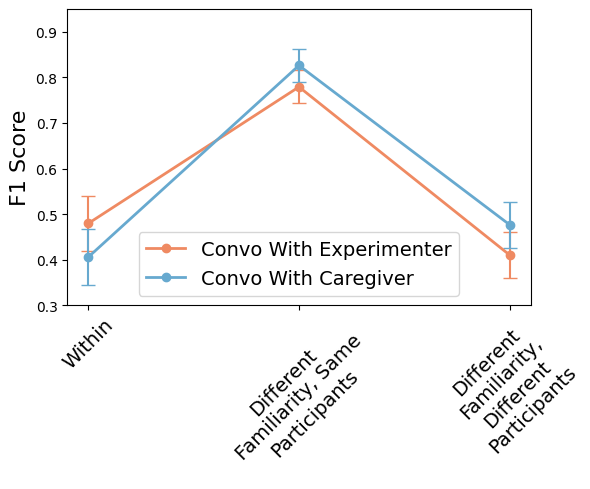

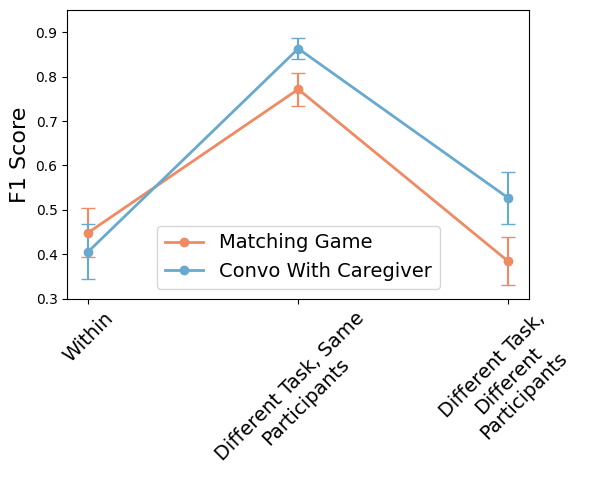

,test_type,model_type,test_name,f1_average,f1_average_eb
1,Within,Convo With Caregiver,Qfam_Qfam_20,0.405883,0.061534
5,Within,Matching Game,MG_MG_20,0.448741,0.054250
0,"Different Task, Same Participants",Convo With Caregiver,Qfam_MG_80,0.863046,0.023616
4,"Different Task, Same Participants",Matching Game,MG_Qfam_80,0.771520,0.037536
2,"Different Task, Different Participants",Convo With Caregiver,Qfam_MG_20,0.526651,0.058511
3,"Different Task, Different Participants",Matching Game,MG_Qfam_20,0.383917,0.053859


In [4]:
functions.dimension_plot('familiarity')
functions.dimension_plot('task')

## Extracting individual model performance

+----+------------------------+---------------+---------------+------------------+------------------+
|    | test_type              |   Sensitivity |   Specificity |   eb_sensitivity |   eb_specificity |
|----+------------------------+---------------+---------------+------------------+------------------|
|  2 | Within                 |      0.637427 |      0.824477 |        0.022649  |        0.0498935 |
|  1 | Different Task,        |      0.556617 |      0.689494 |        0.0103937 |        0.0388939 |
|    | Same Participants      |               |               |                  |                  |
|  0 | Different Task,        |      0.190476 |      0.924731 |        0.147542  |        0.058303  |
|    | Different Participants |               |               |                  |                  |
+----+------------------------+---------------+---------------+------------------+------------------+


/work/bachelor/Python/functions.py:504: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  results['test_type'] = results['test_type'].replace(new_names)


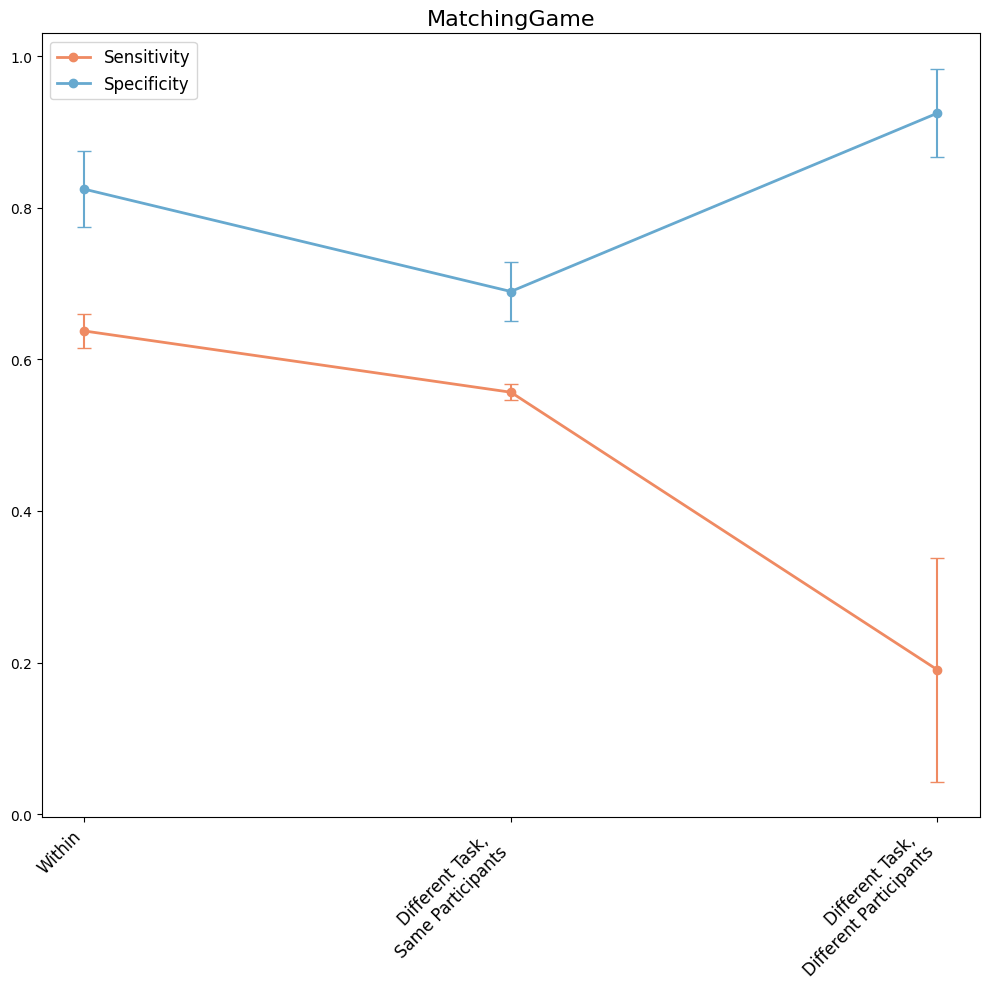

In [5]:
# MatchingGame
plot_values = functions.class_preparation('MatchingGame', ['MG_MG_20', 'MG_Qfam_80', 'MG_Qfam_20'], new_names = {
    'MG_MG_20': 'Within',
    'MG_Qfam_80': 'Different Task, \nSame Participants',
    'MG_Qfam_20': 'Different Task, \nDifferent Participants'
})
print(tabulate(plot_values, headers='keys', tablefmt='psql'))

functions.class_plot('MatchingGame', plot_values)

+----+-------------------------+---------------+---------------+------------------+------------------+
|    | test_type               |   Sensitivity |   Specificity |   eb_sensitivity |   eb_specificity |
|----+-------------------------+---------------+---------------+------------------+------------------|
|  4 | Within                  |      0.190476 |      0.924731 |       0.147542   |        0.058303  |
|  0 | Different Task,         |      0.53273  |      0.579818 |       0.00505927 |        0.0152015 |
|    | Same Participants       |               |               |                  |                  |
|  1 | Different Task,         |      0.588538 |      0.819089 |       0.0330053  |        0.0479434 |
|    | Different Participants  |               |               |                  |                  |
|  3 | Different Familiarity,  |      0.554498 |      0.625292 |       0.0120644  |        0.0332792 |
|    | Same Participants       |               |               |         

/work/bachelor/Python/functions.py:504: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  results['test_type'] = results['test_type'].replace(new_names)


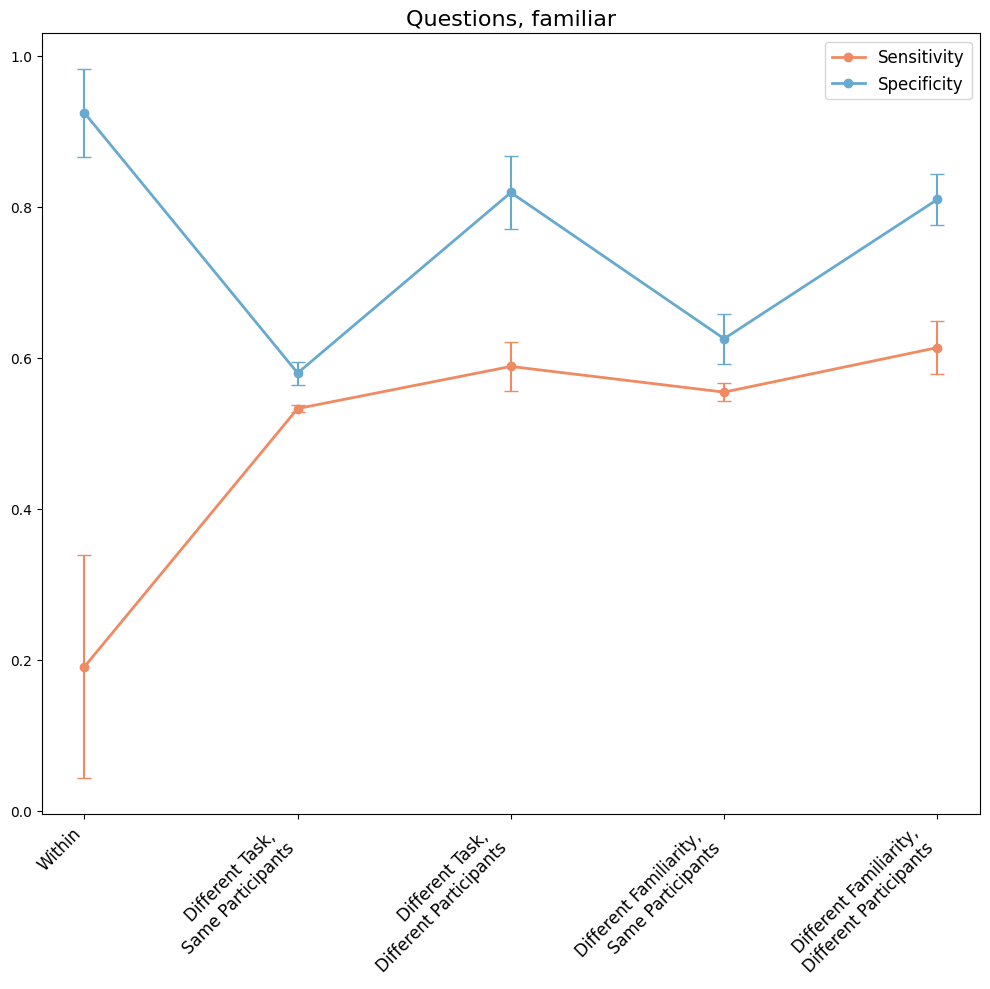

In [6]:
# Qfam
plot_values = functions.class_preparation('Qfam', ['Qfam_Qfam_20', 'Qfam_MG_80', 'Qfam_MG_20', 'Qfam_Qunfam_80', 'Qfam_Qunfam_20'], new_names = {
    'Qfam_Qfam_20': 'Within',
    'Qfam_MG_80': 'Different Task, \nSame Participants',
    'Qfam_MG_20': 'Different Task, \nDifferent Participants',
    'Qfam_Qunfam_80': 'Different Familiarity, \nSame Participants',
    'Qfam_Qunfam_20': 'Different Familiarity,\n Different Participants'
    })

print(tabulate(plot_values, headers='keys', tablefmt='psql'))
functions.class_plot('Questions, familiar', plot_values)


/work/bachelor/Python/functions.py:504: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  results['test_type'] = results['test_type'].replace(new_names)


+----+-------------------------+---------------+---------------+------------------+------------------+
|    | test_type               |   Sensitivity |   Specificity |   eb_sensitivity |   eb_specificity |
|----+-------------------------+---------------+---------------+------------------+------------------|
|  1 | Within                  |      0.433333 |      0.866667 |        0.167829  |        0.0516398 |
|  0 | Different Familiarity,  |      0.570113 |      0.70839  |        0.0136669 |        0.0287809 |
|    |  Same Participants      |               |               |                  |                  |
|  2 | Different Familiarity,  |      0.438889 |      0.896296 |        0.170022  |        0.0448133 |
|    |  Different Participants |               |               |                  |                  |
+----+-------------------------+---------------+---------------+------------------+------------------+


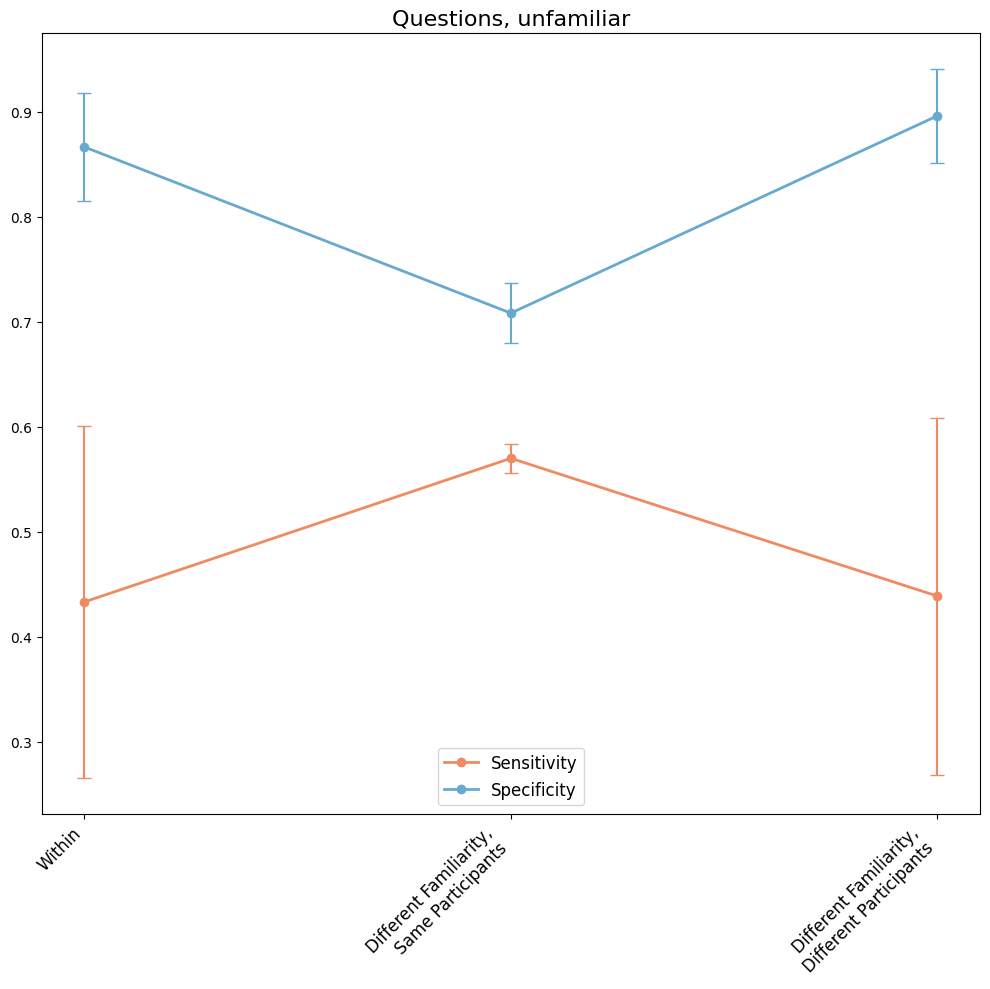

In [7]:
# Qunfam
plot_values = functions.class_preparation('Qunfam', ['Qunfam_Qunfam_20', 'Qunfam_Qfam_80', 'Qunfam_Qfam_20'], new_names = {
    'Qunfam_Qunfam_20': 'Within',
    'Qunfam_Qfam_80': 'Different Familiarity,\n Same Participants',
    'Qunfam_Qfam_20': 'Different Familiarity,\n Different Participants'
})

print(tabulate(plot_values, headers='keys', tablefmt='psql'))
functions.class_plot('Questions, unfamiliar', plot_values)

### Heatmaps

In [8]:
same = functions.heatmaps_preparation('same')

different = functions.heatmaps_preparation('different')

In [9]:
print(same)

      ID  MG_Qfam_80_1  Qfam_MG_80_1  Qfam_Qunfam_80_1  Qunfam_Qfam_80_1  \
0   1099           1.0           1.0               1.0               1.0   
1   1351           1.0           1.0               1.0               1.0   
2   2307           1.0           1.0               1.0               1.0   
3   2411           0.0           0.0               0.0               1.0   
4   2586           1.0           1.0               1.0               1.0   
5   2817           1.0           1.0               1.0               1.0   
6   2883           1.0           1.0               1.0               1.0   
7   2903           1.0           1.0               1.0               1.0   
8   2990           1.0           1.0               1.0               1.0   
9   3048           1.0           1.0               1.0               1.0   
10  3399           1.0           1.0               1.0               1.0   
11  3682           1.0           1.0               1.0               1.0   
12  3830    

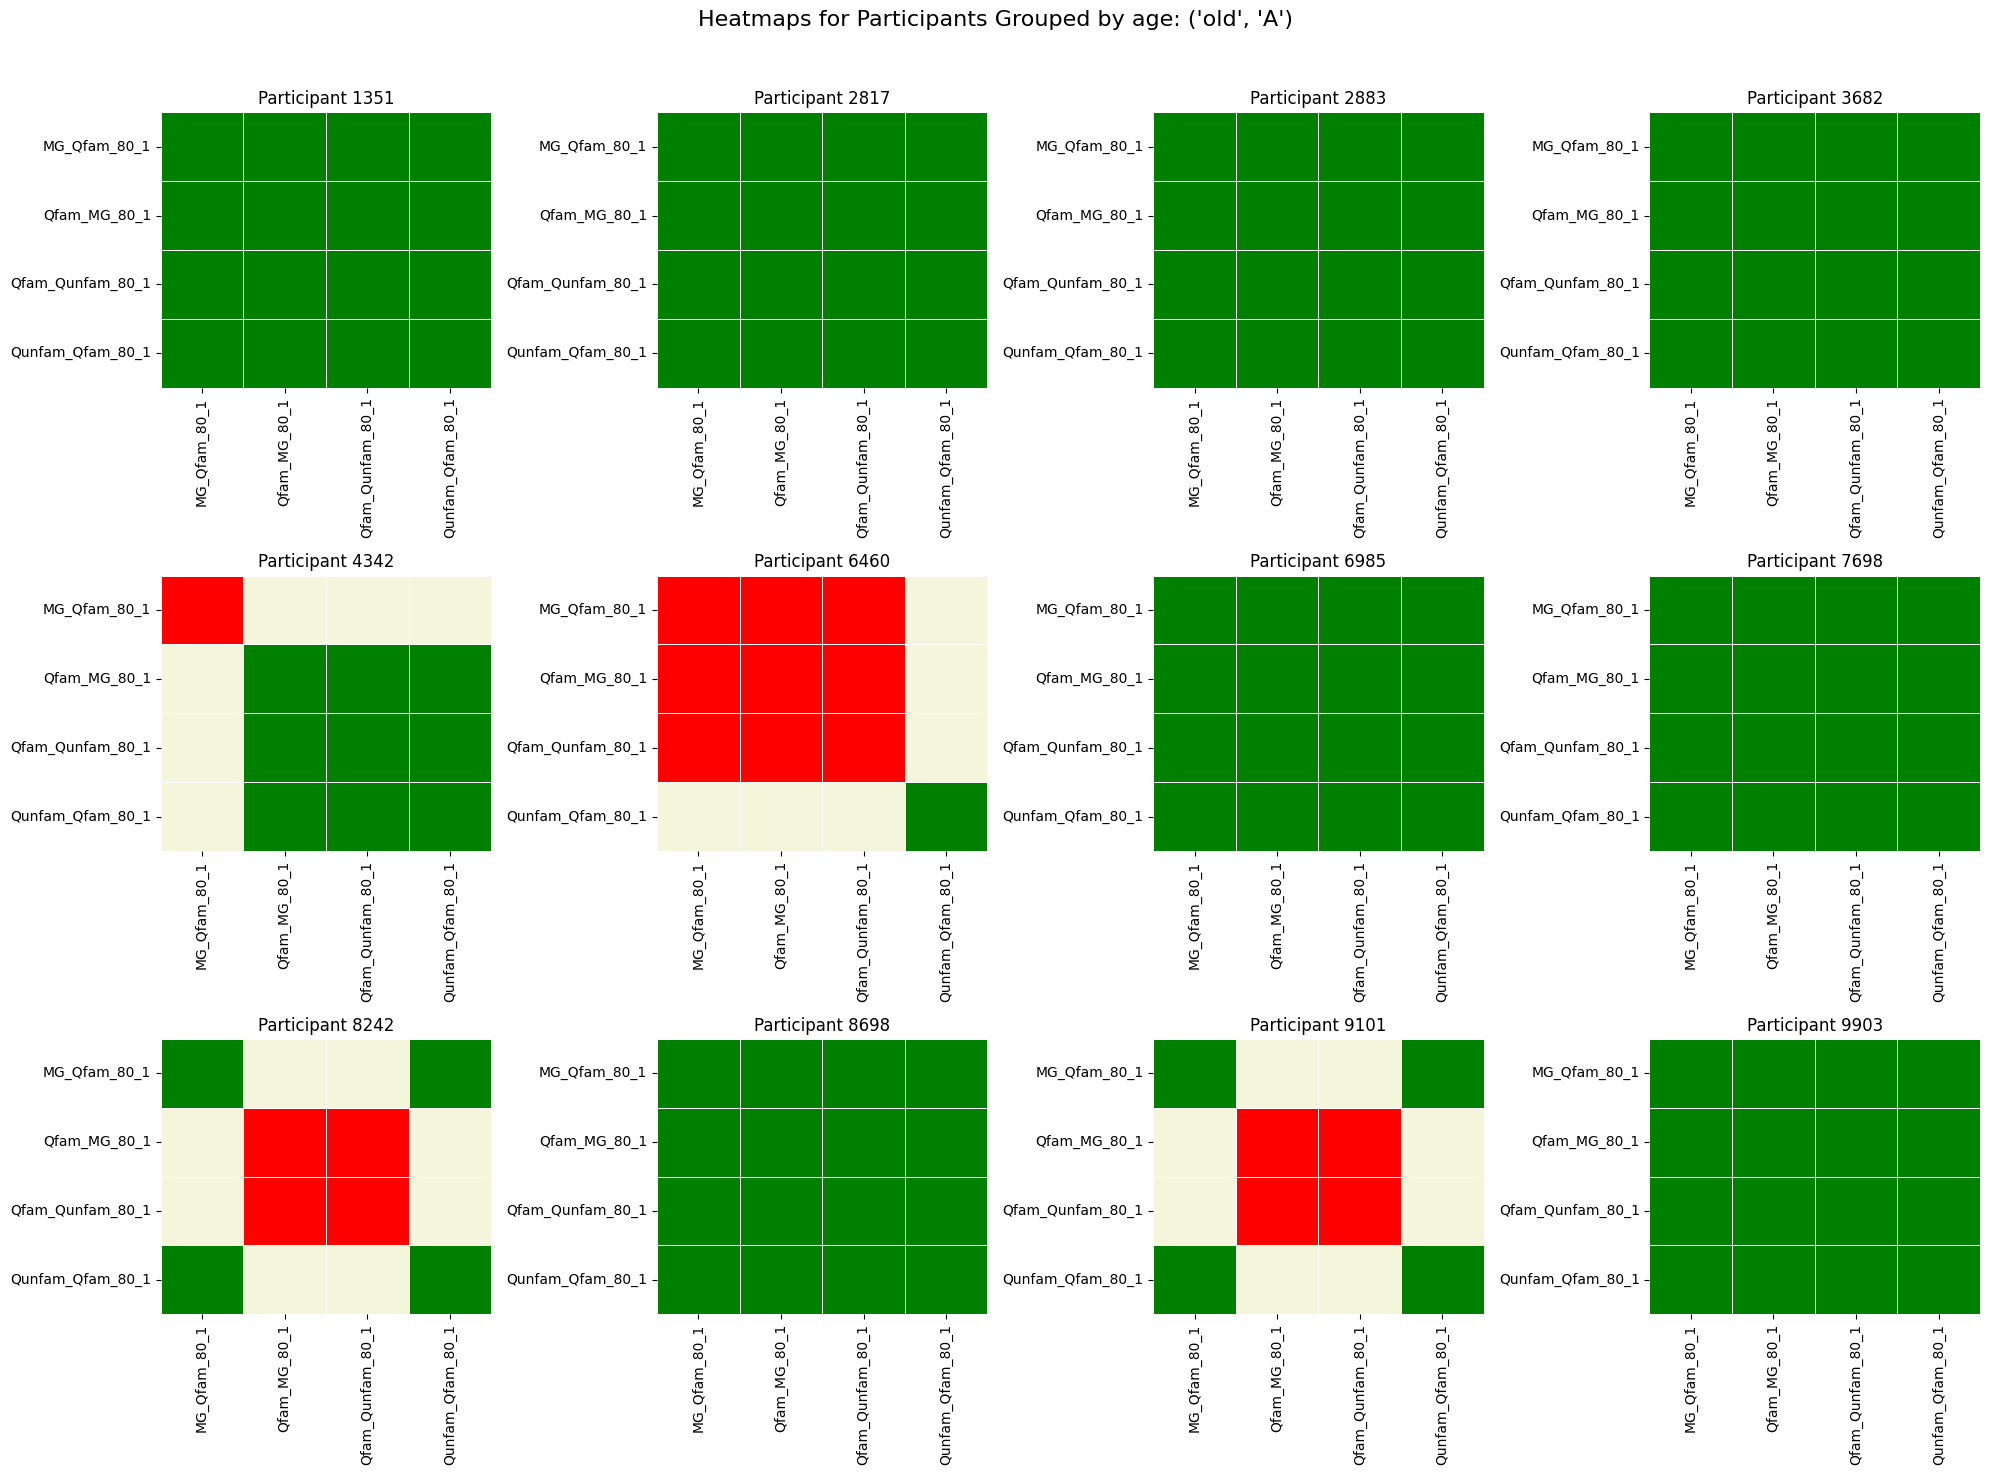

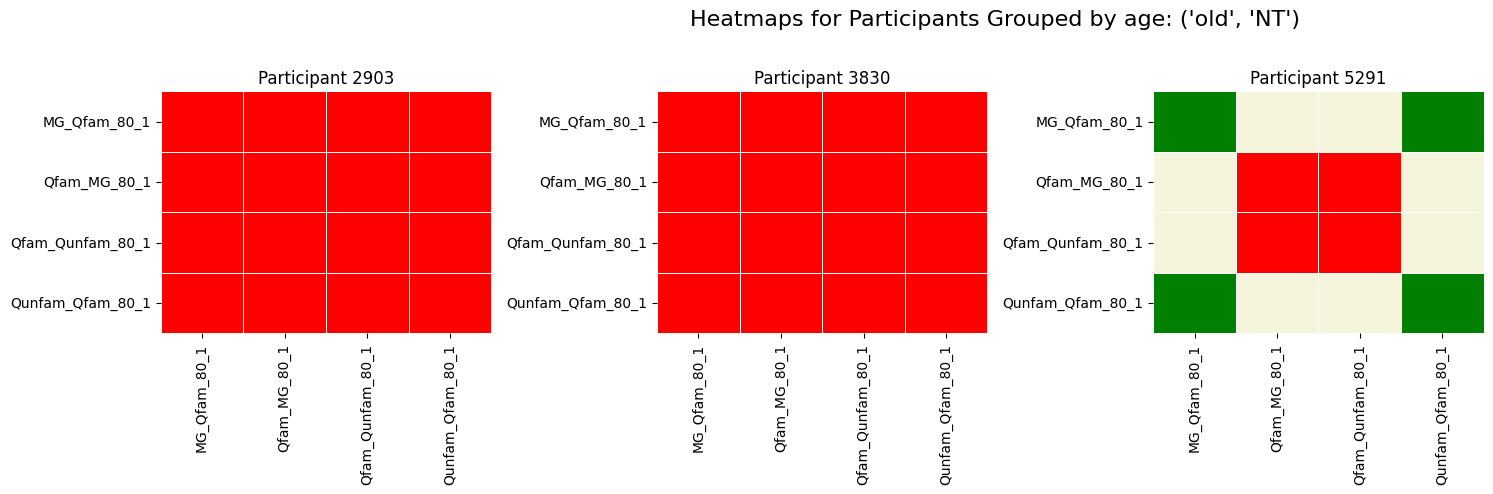

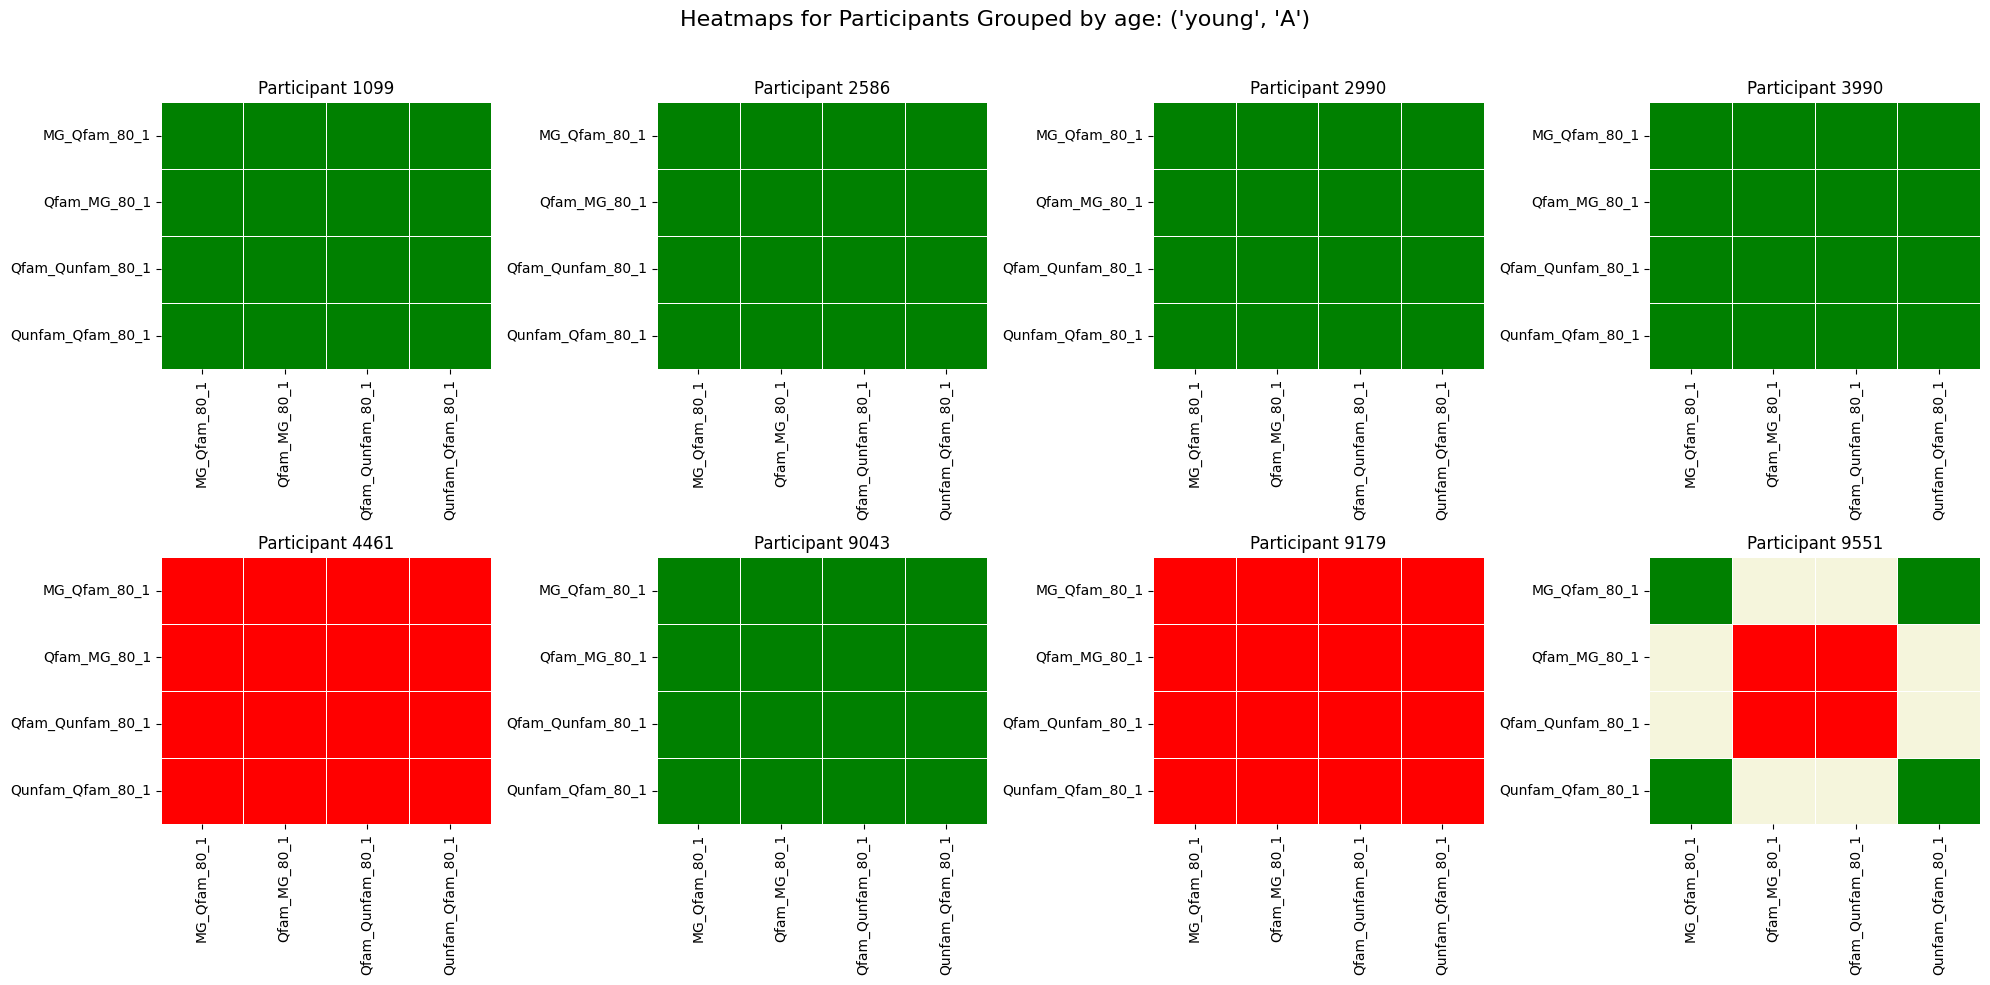

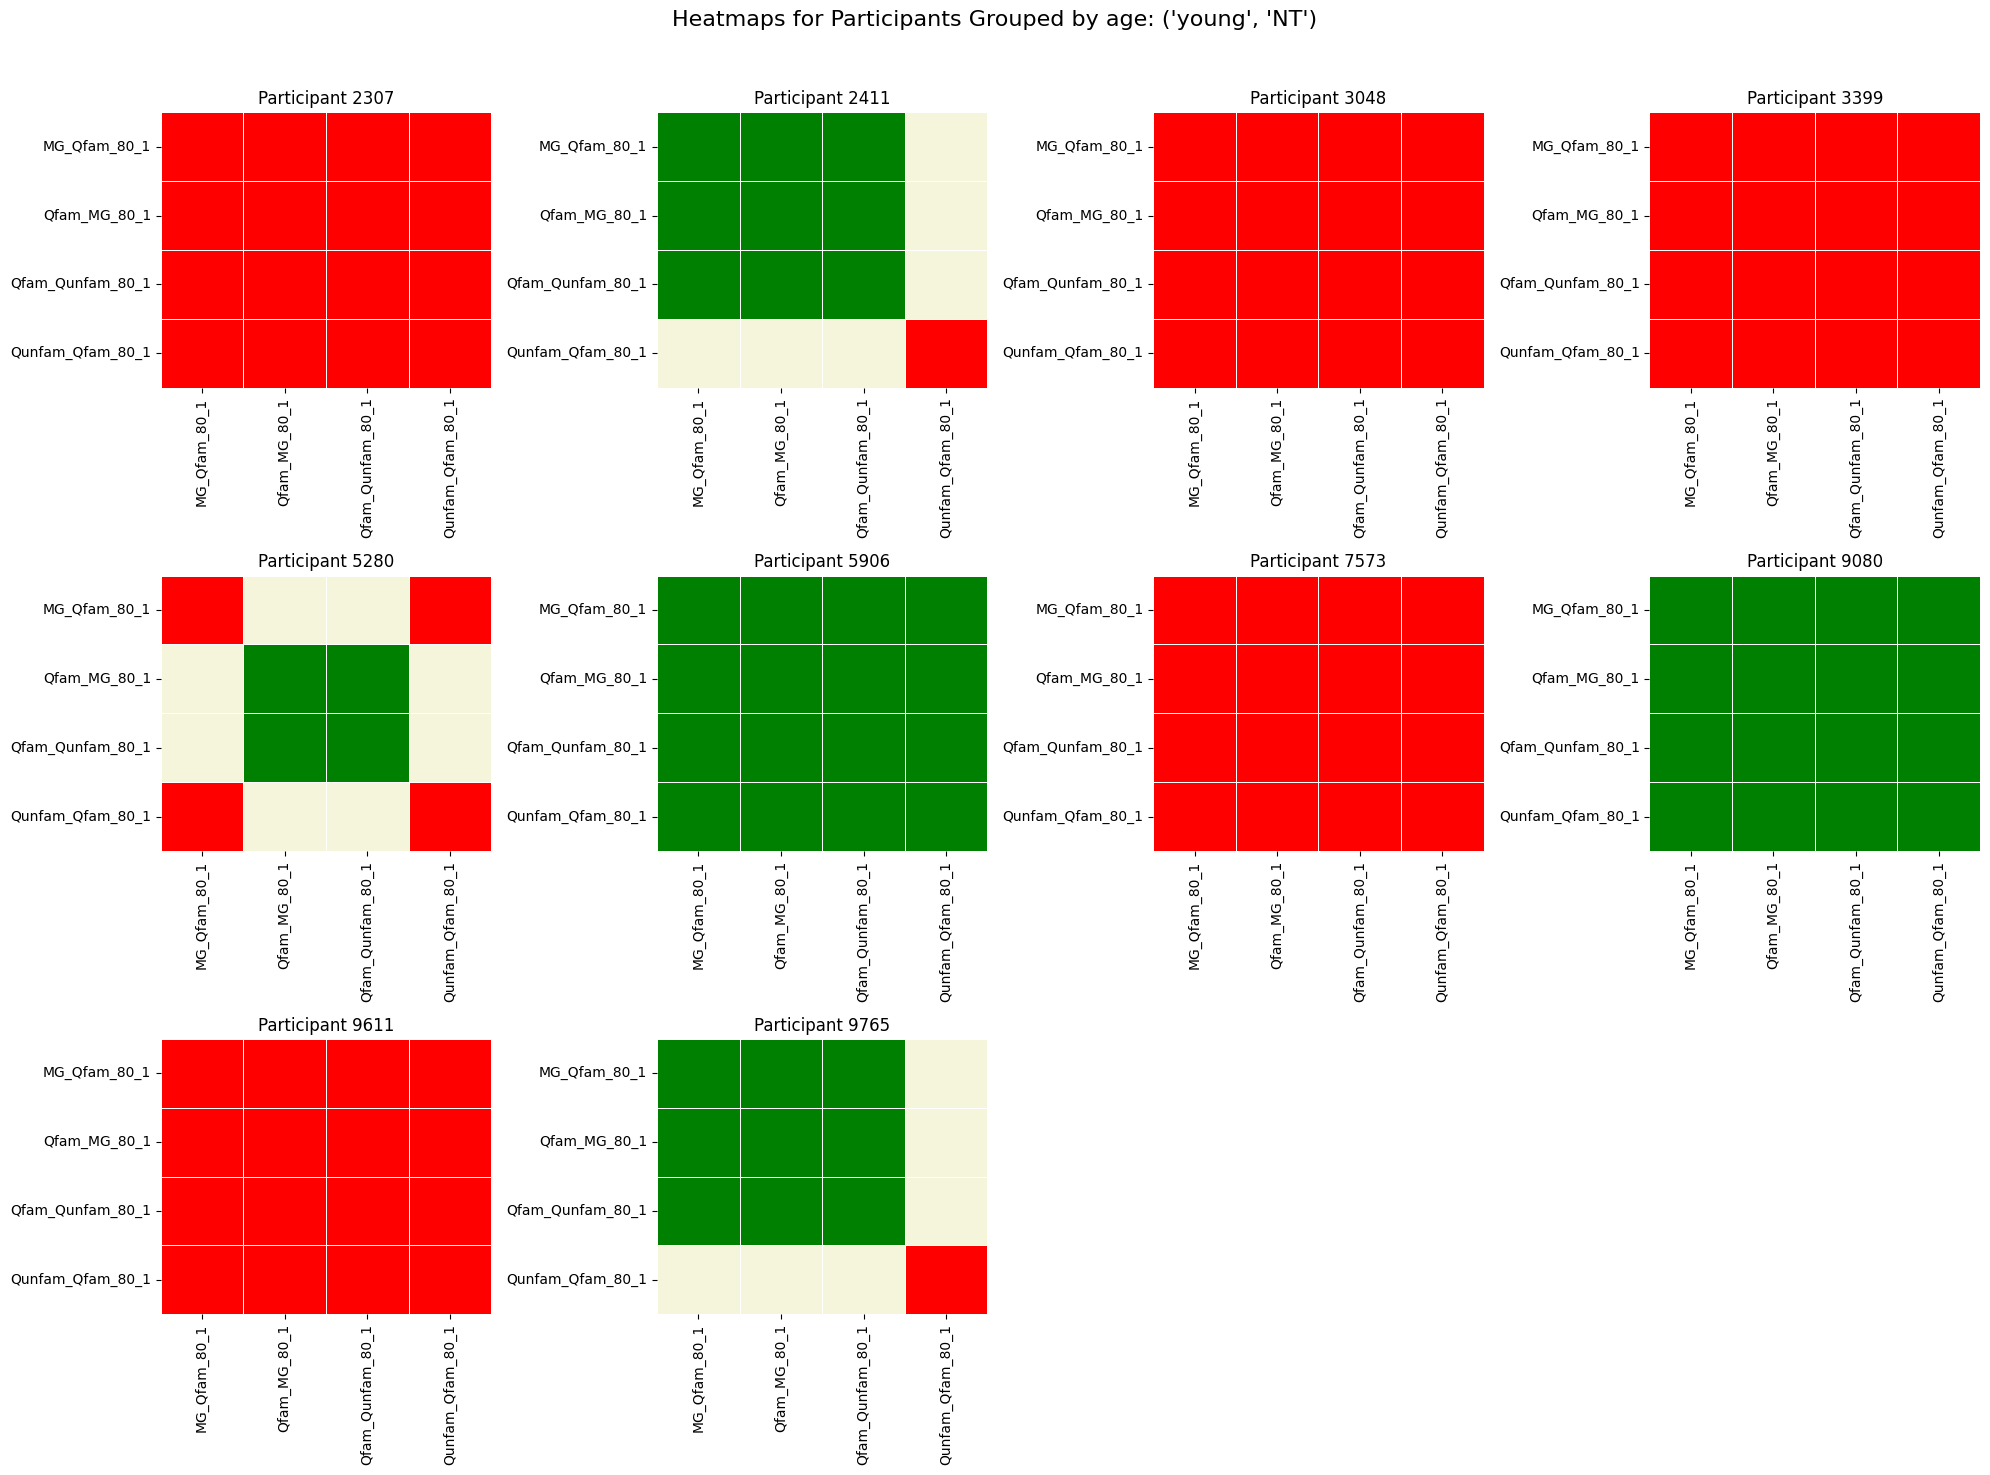

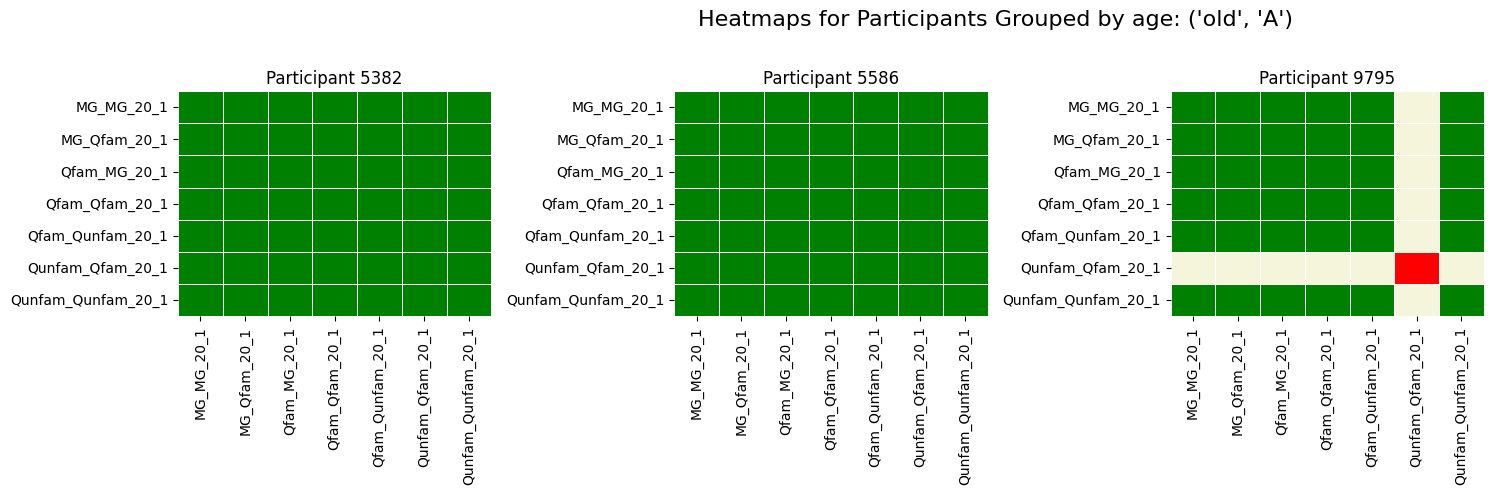

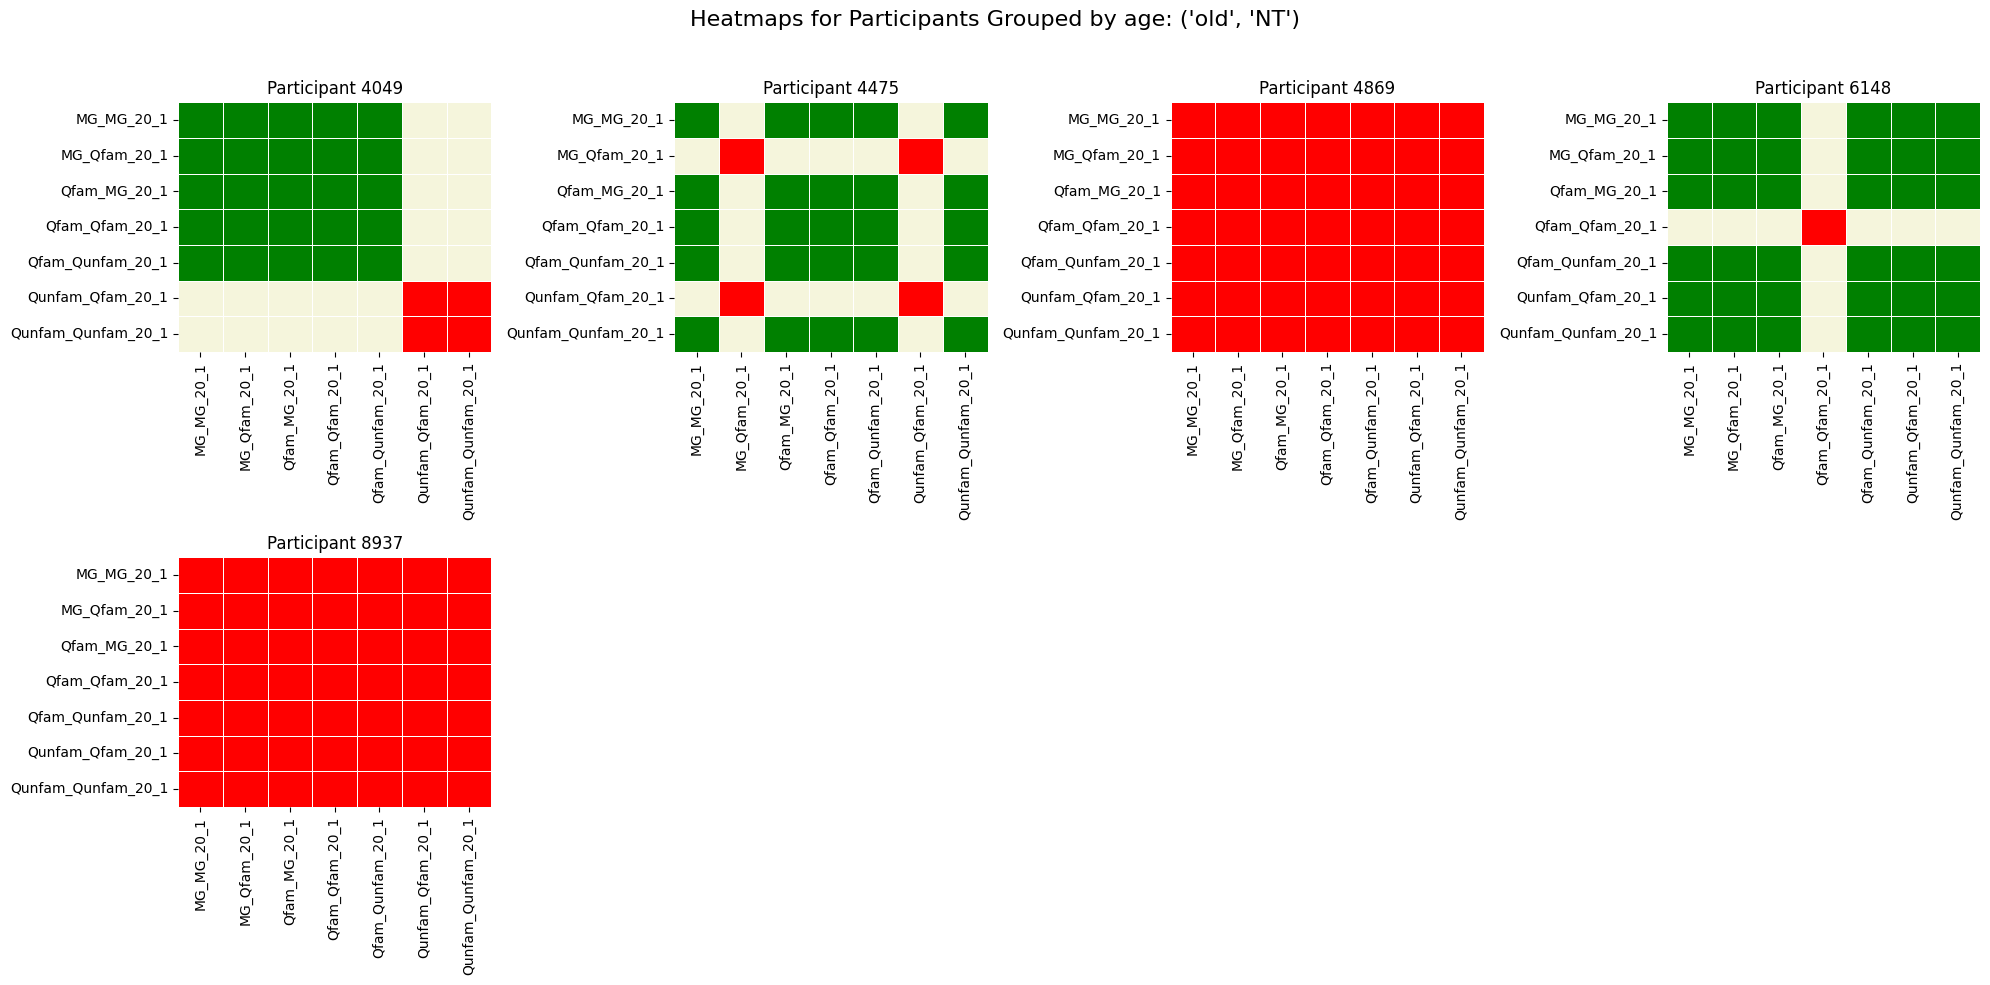

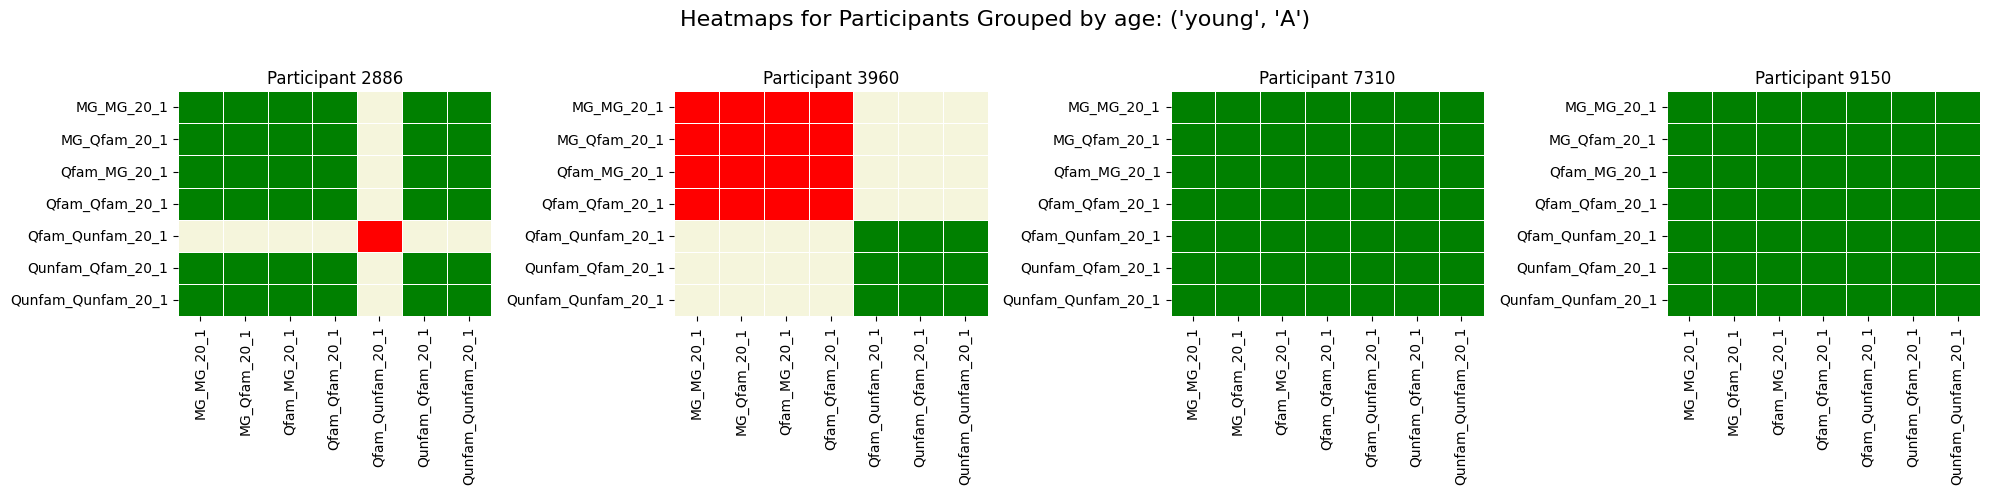

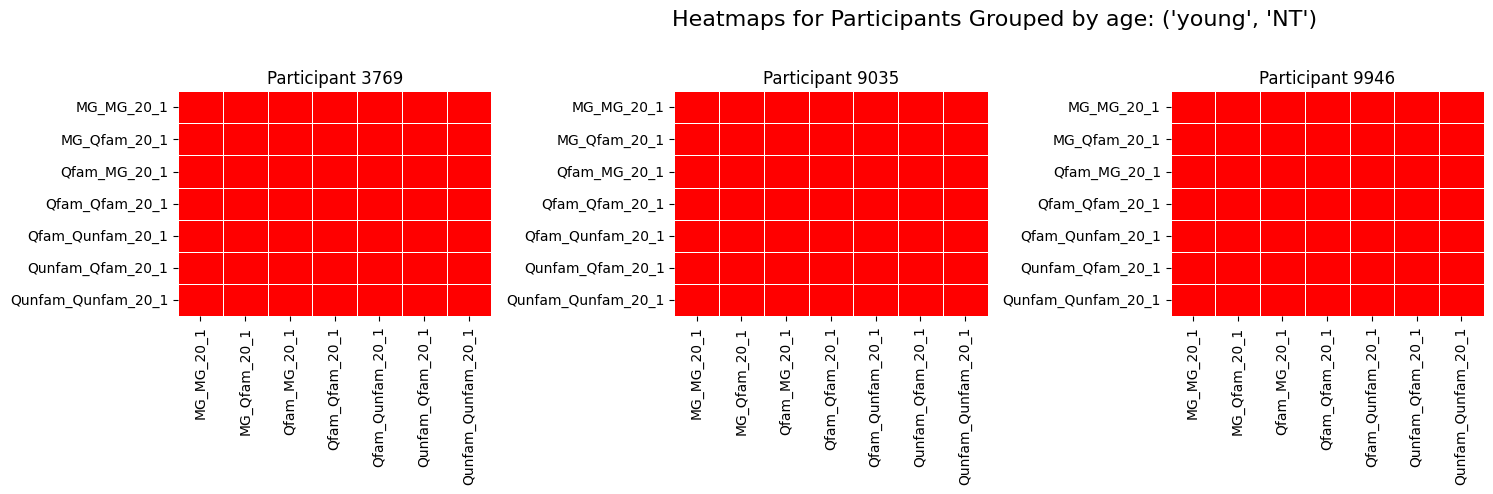

In [10]:
# age
functions.heatmaps_plot('age', same)
functions.heatmaps_plot('age', different)

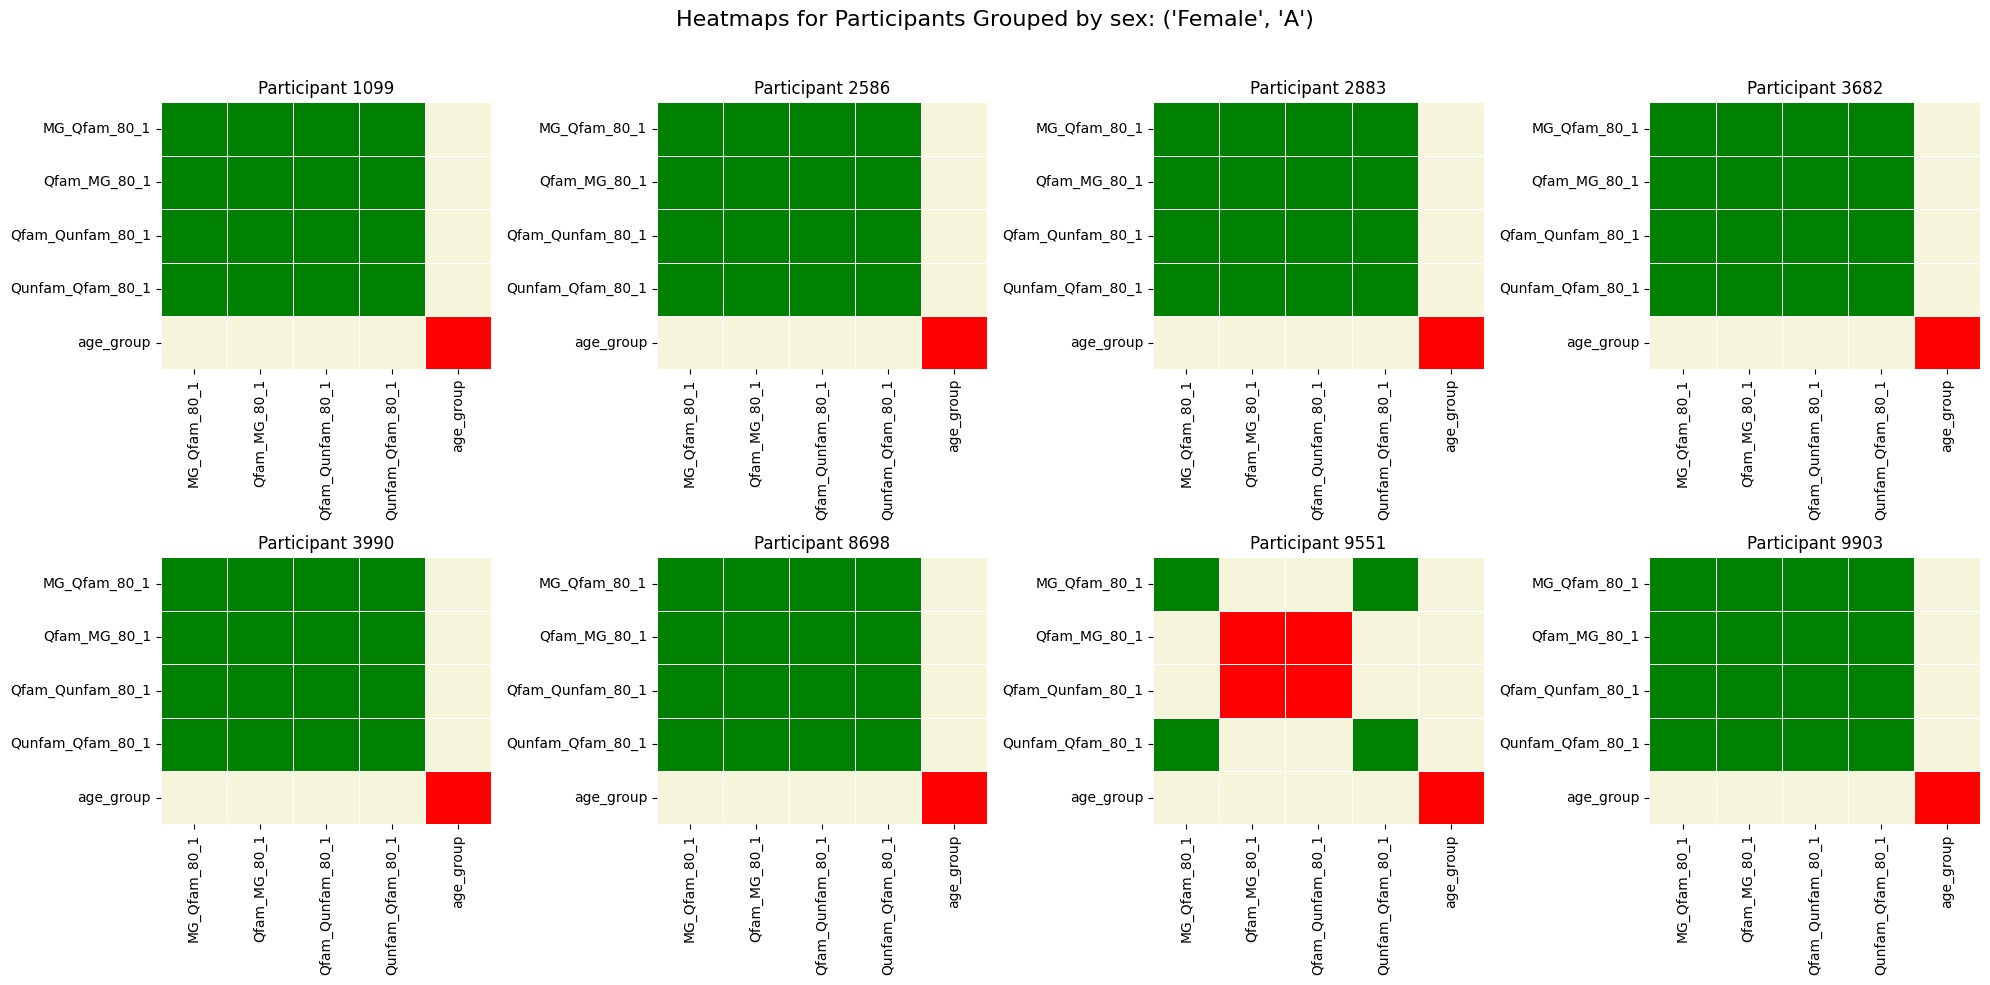

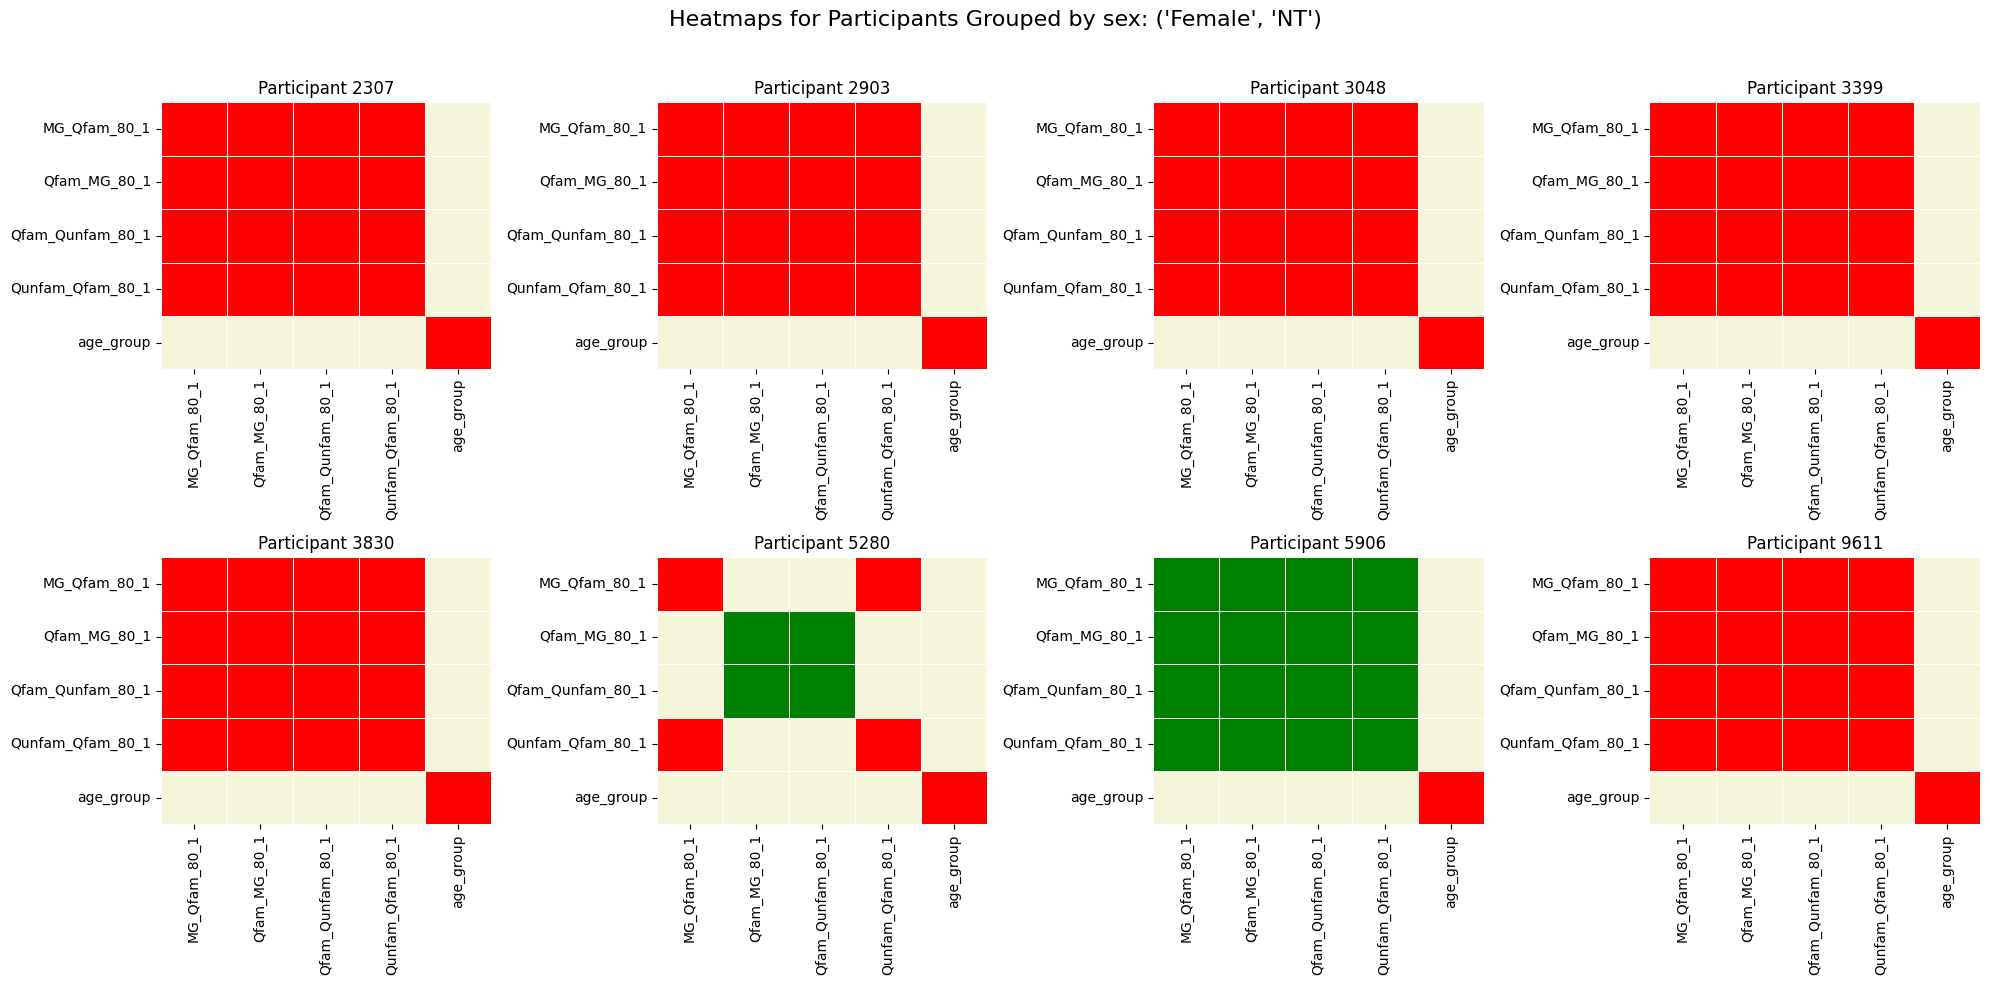

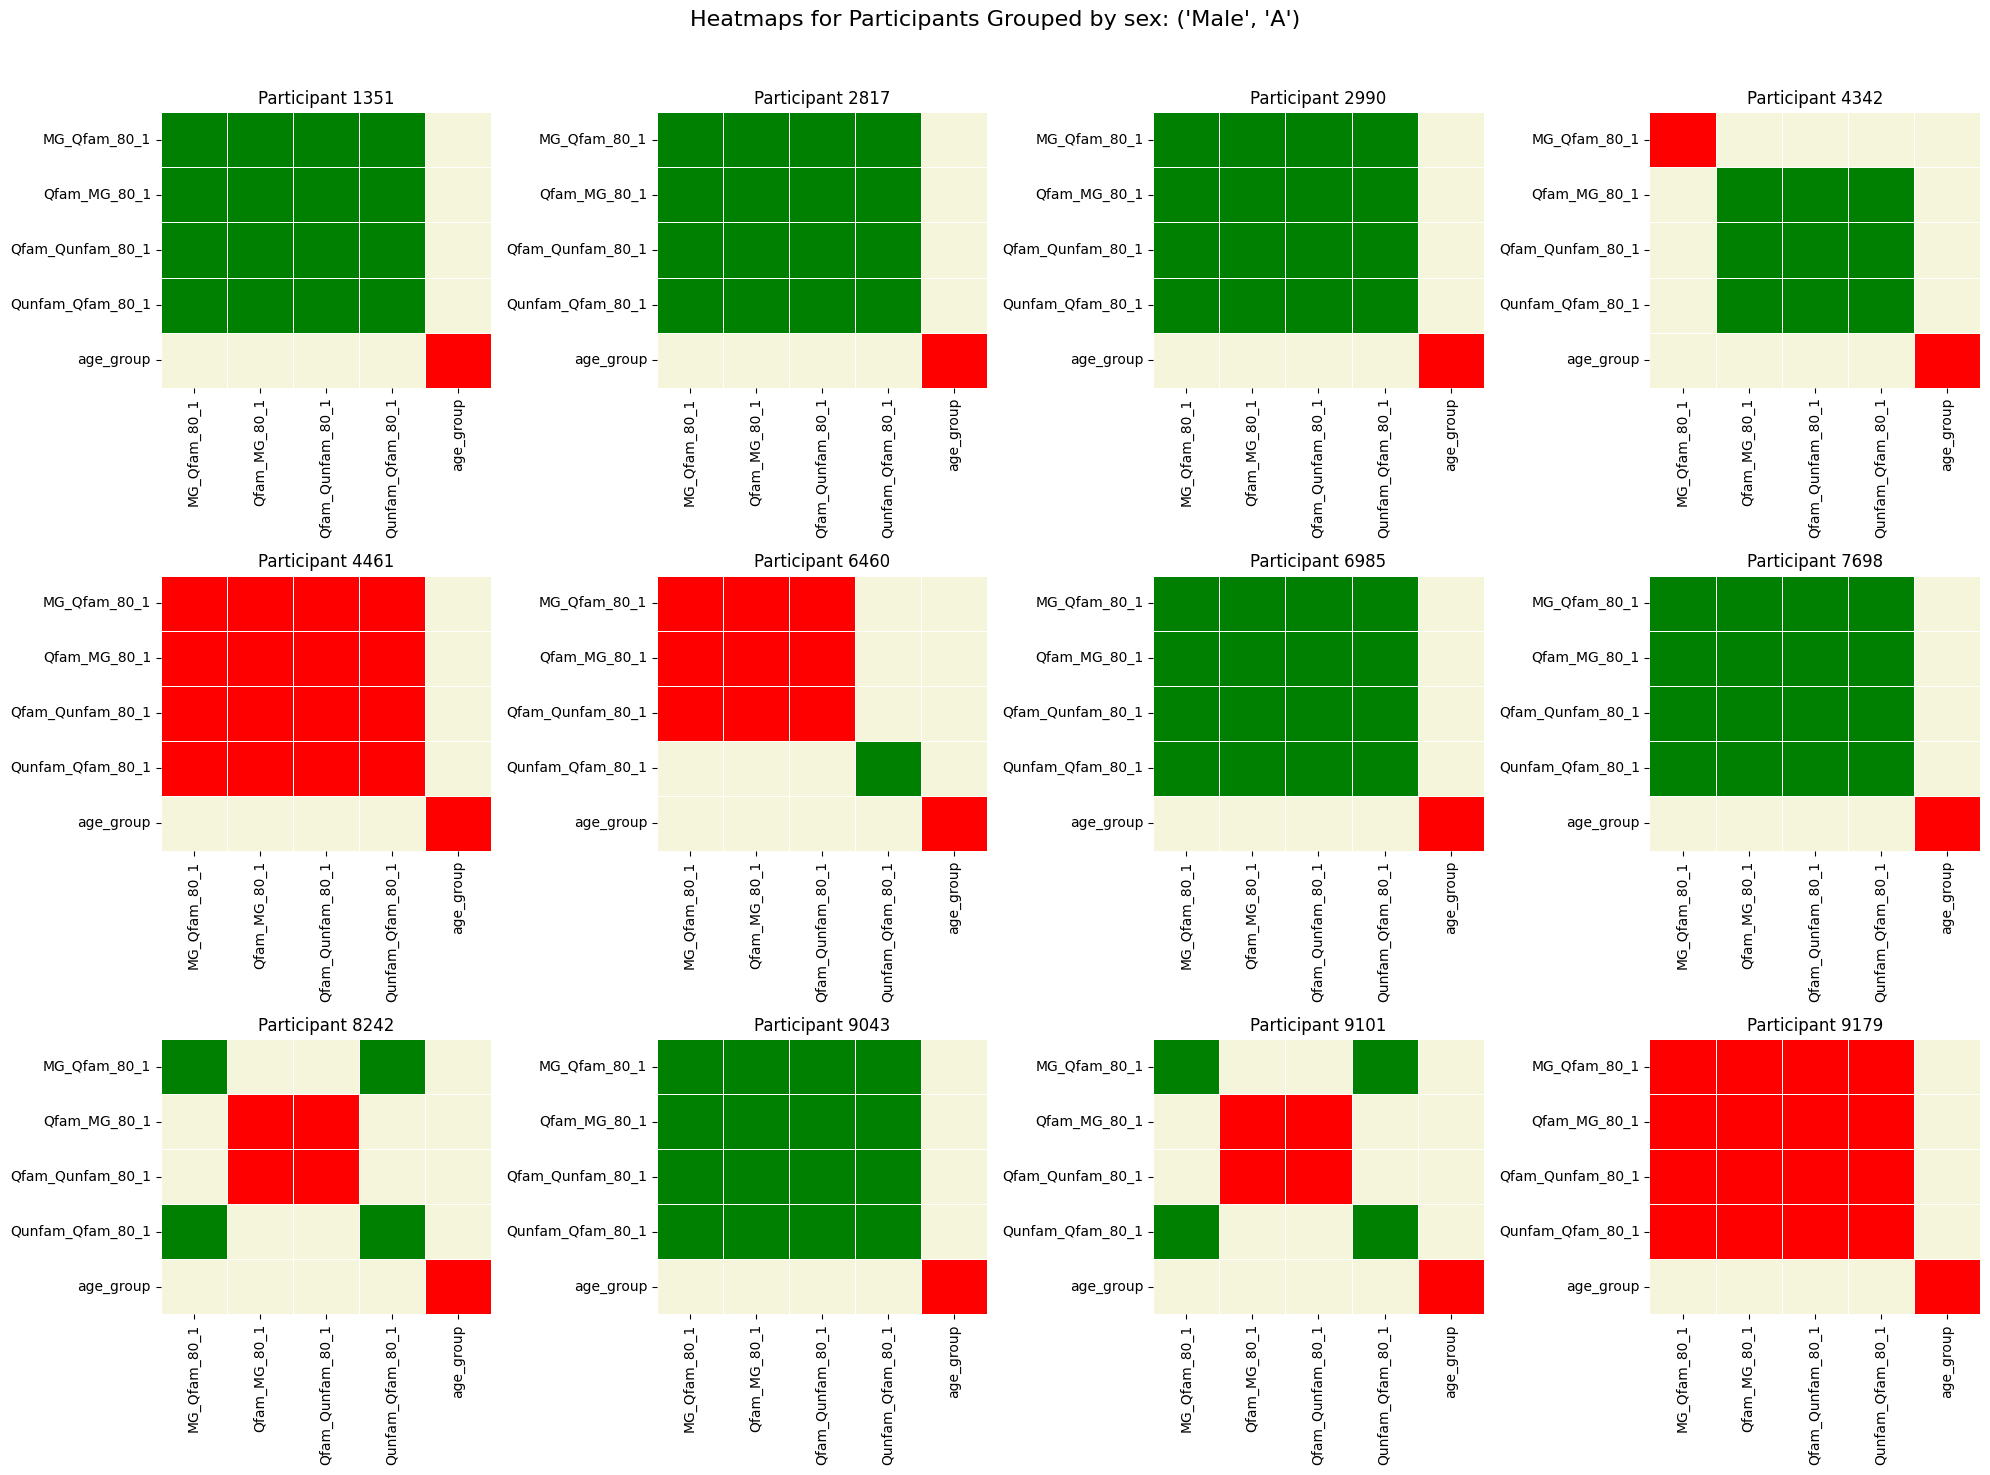

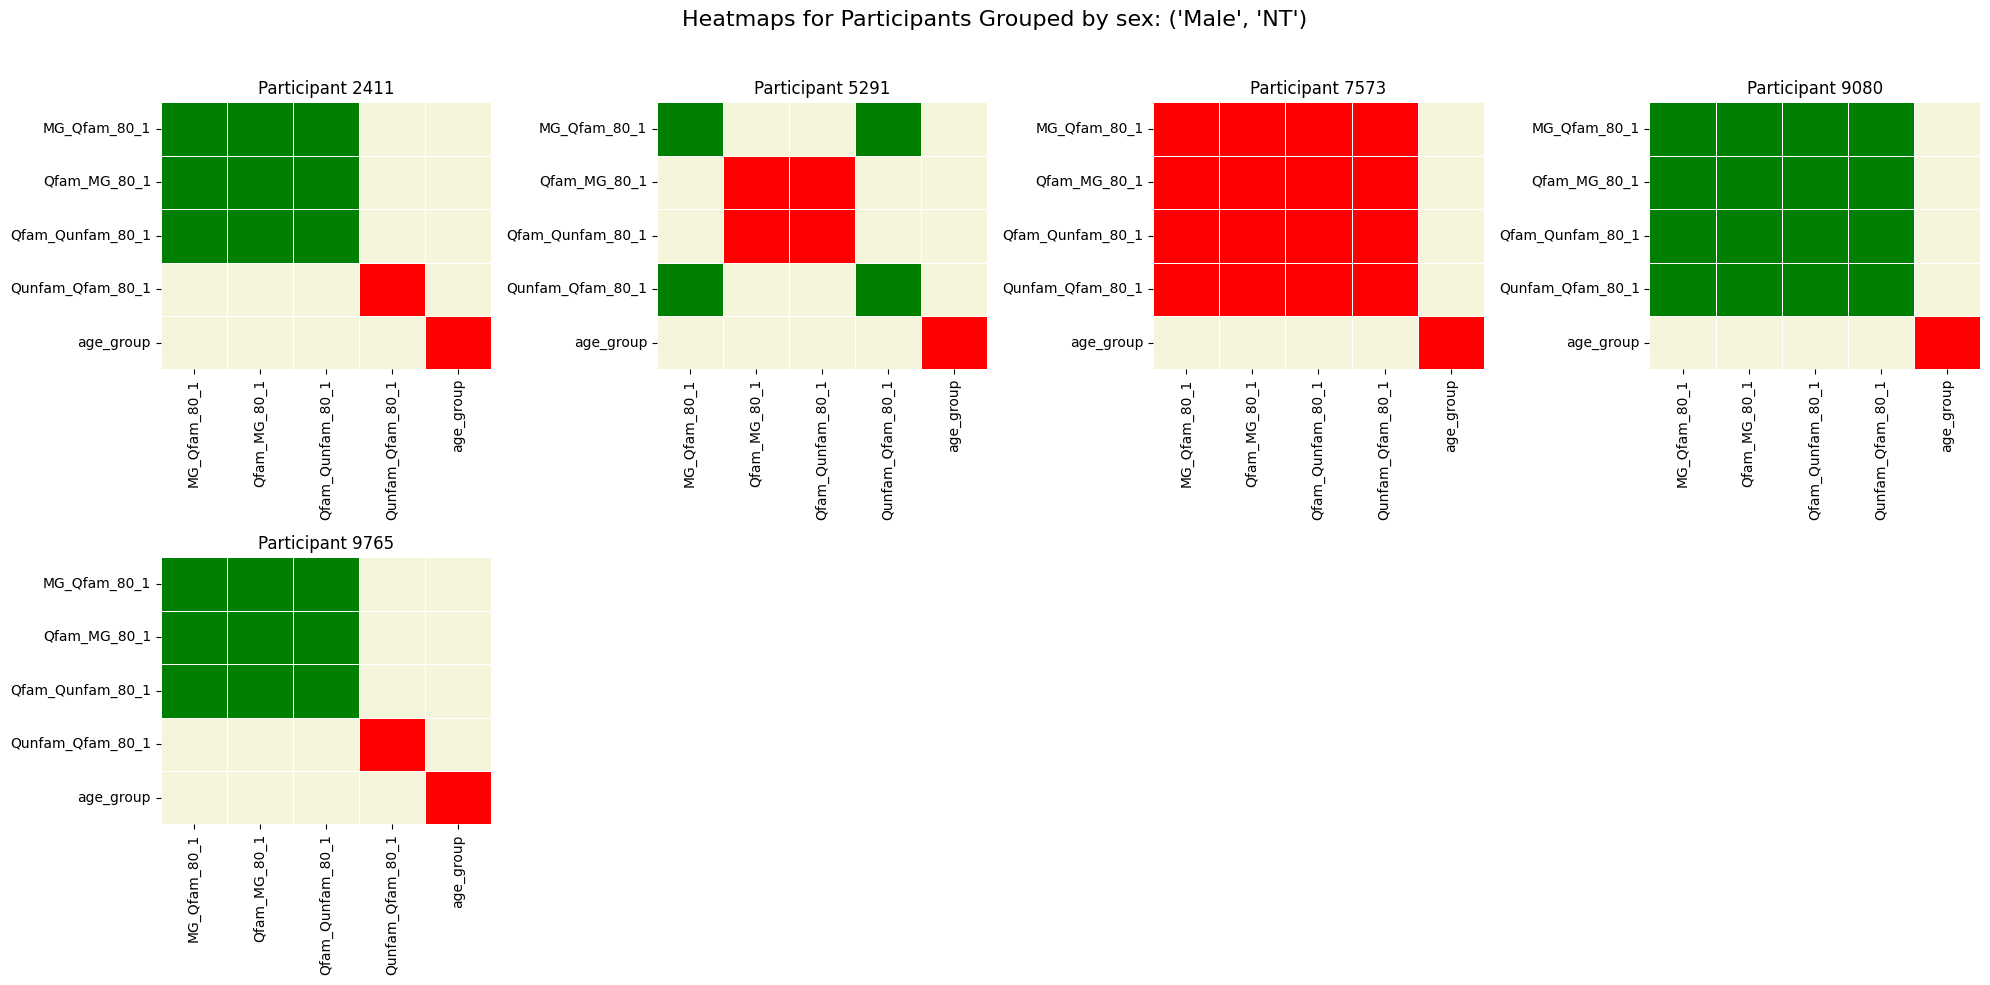

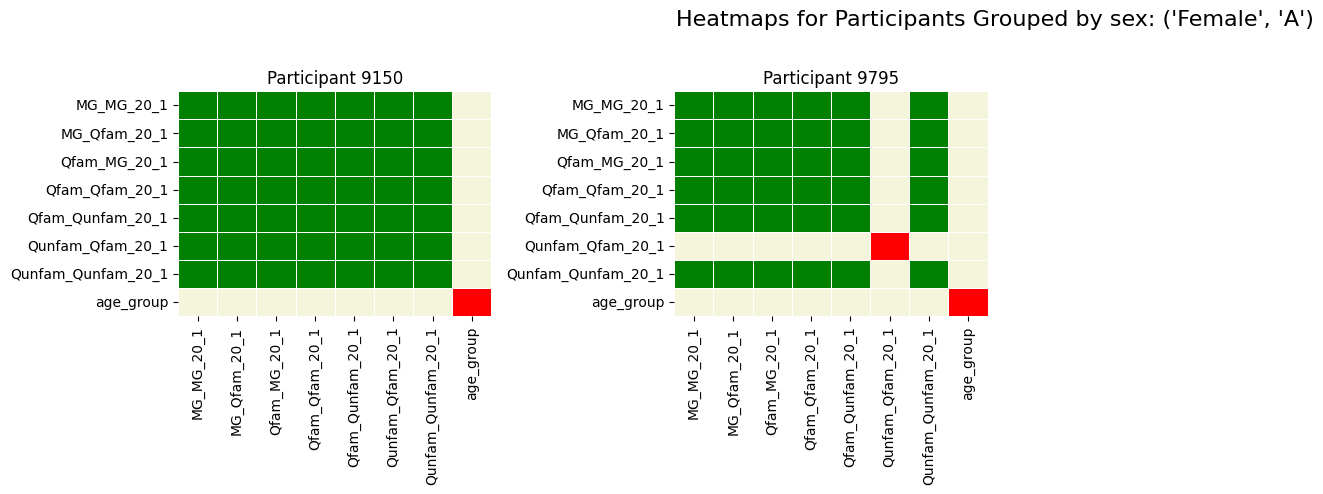

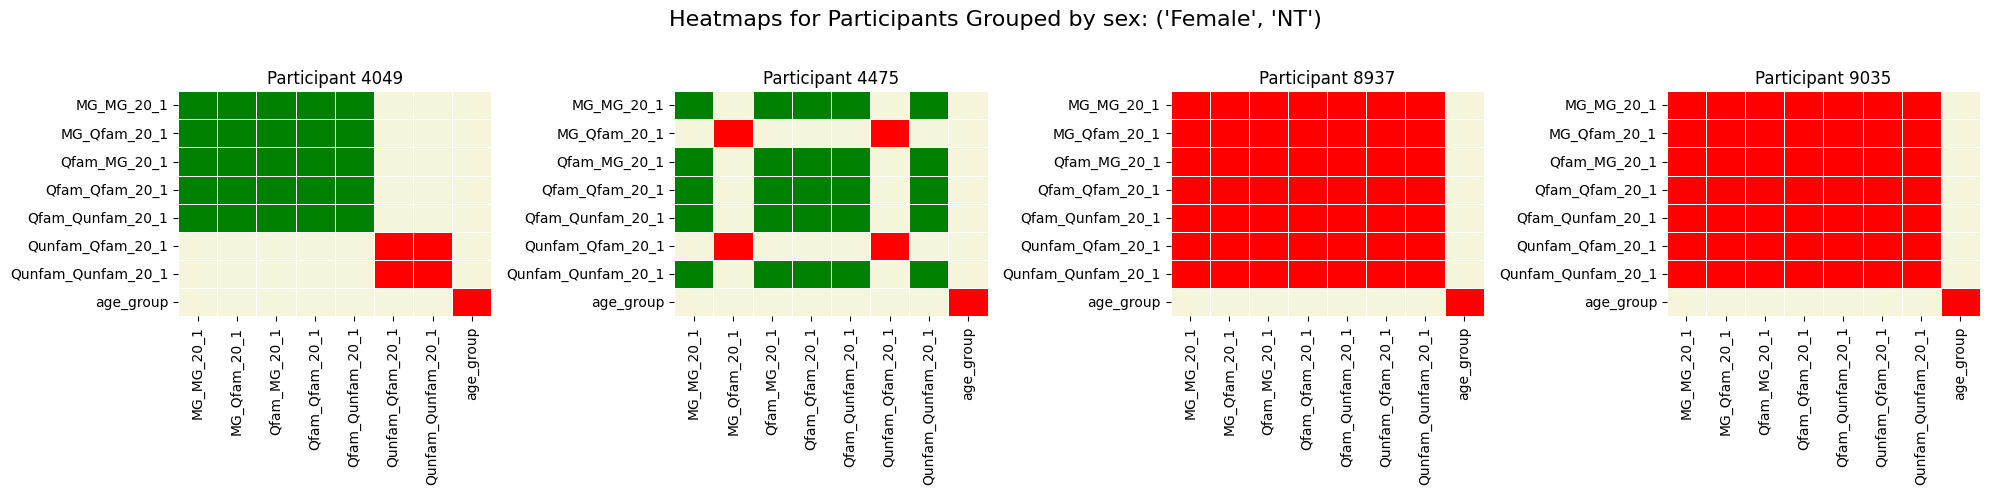

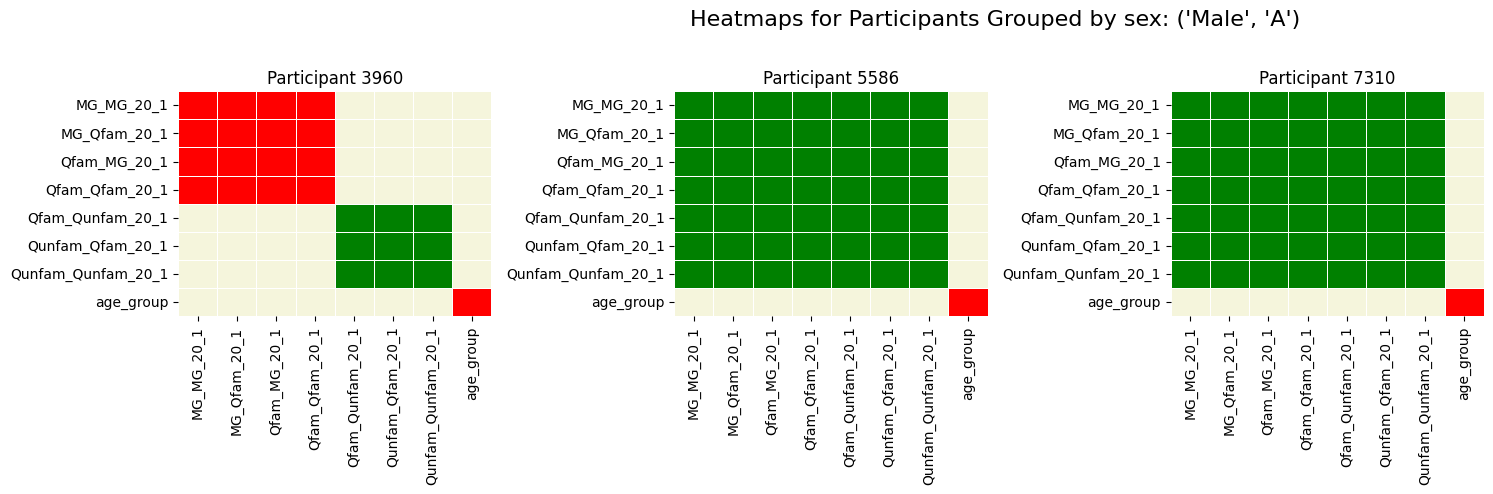

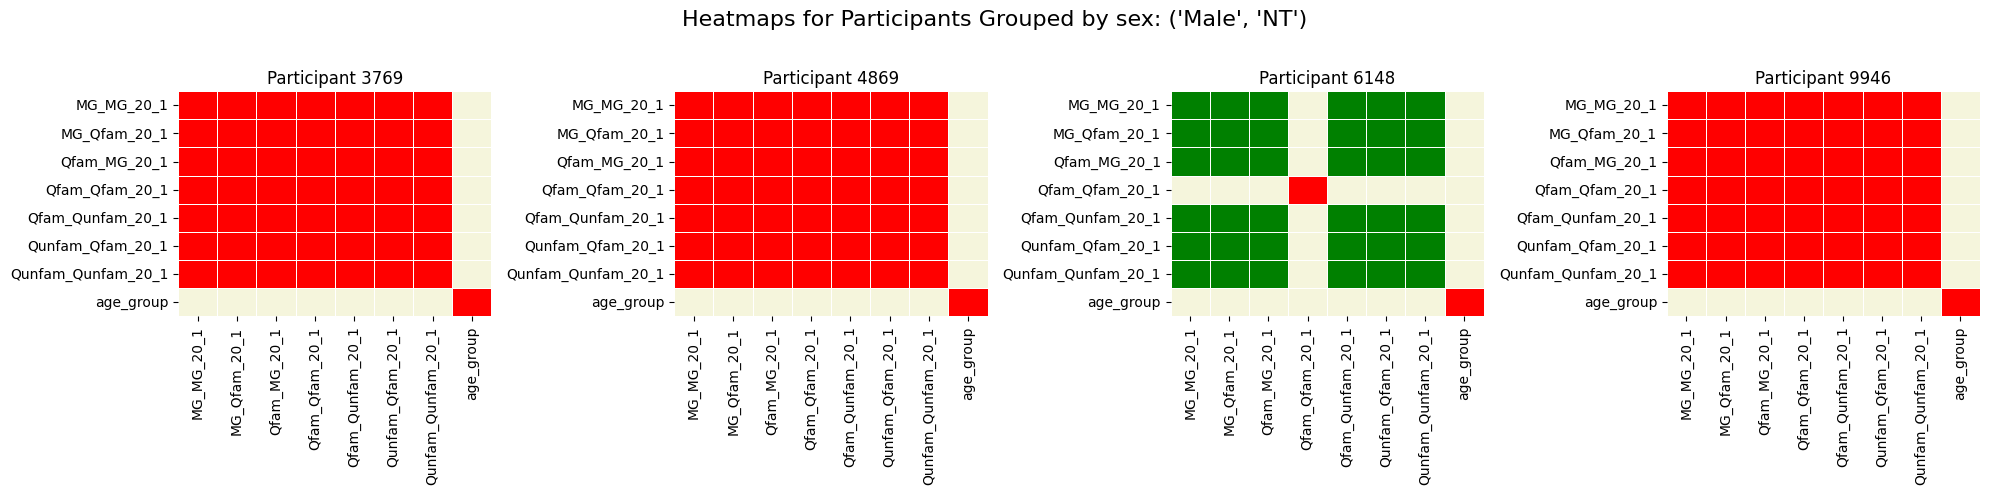

In [11]:
# sex
functions.heatmaps_plot('sex', same)
functions.heatmaps_plot('sex', different)